**Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix

**DATA PREPROCESSING**

In [ ]:
df= pd.read_csv("/content/New_data.csv")

df.replace('?', pd.NA, inplace=True)

# List of categorical columns for which you want to impute missing values
categorical_cols = ['ethnicity', 'relation']

# Impute missing values with the mode of each column
for col in categorical_cols:
    mode_val = df[col].mode().iloc[0]  # mode() returns a Series, so use iloc[0] to get the first value
    df[col].fillna(mode_val, inplace=True)


numerical_cols = ['age']  # Add all your numerical columns here
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Replace missing values with the mean for each numerical column
for col in numerical_cols:
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

columns_to_replace = ['jundice', 'Class/ASD','gender','relation']
df[columns_to_replace] = df[columns_to_replace].replace({'Self':1,'self':1,'Parent':1,'Healthcare':1,'Health care professional':1,'Health Care Professional':1,'Others':0,'Relative':0,'family member':0,'f':0, 'm':1, 'YES': 1, 'NO': 0, 'yes':1,'no':0,'Yes':1,'No':0})

df=df.drop('ethnicity',axis=1)

df.head()

df.to_csv("Preprocessed_data.csv", index=False)

**DATA STANDARDIZATION**

In [ ]:
X = df.drop(columns = 'Class/ASD', axis=1)
Y = df['Class/ASD']

scaler = StandardScaler()
scaler.fit(X)
standardized_data = scaler.transform(X)
print(standardized_data)

[[-0.84152725  0.87560129 -1.30875756 -0.51605613  1.14940014]
 [-0.84152725  0.74709681  0.76408346 -0.51605613  1.14940014]
 [ 1.18831564  0.93985353  0.76408346  1.93777369  1.14940014]
 ...
 [ 1.18831564 -0.66645247  0.76408346  1.93777369 -0.87001903]
 [-0.84152725 -0.66645247  0.76408346 -0.51605613 -0.87001903]
 [ 1.18831564 -0.66645247  0.76408346  1.93777369 -0.87001903]]


**TRAINING PROCESS**

In [ ]:
X = standardized_data
Y = df['Class/ASD']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, stratify=Y, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

classifier = svm.SVC(kernel='linear',probability=True)
classifier.fit(X_train, Y_train)

(2154, 5) (1723, 5) (431, 5)


SVC(kernel='linear', probability=True)

In [ ]:
import pickle

with open('svm_model.pkl','wb') as f:
    pickle.dump(classifier,f)

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

**ACCURACY**

In [ ]:
# accuracy score on the training data
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

# accuracy score on the test data
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the training data :  0.893789901334881
Accuracy score of the test data :  0.8955916473317865


**PERFORMANCE MEASURES**

In [ ]:
precision = precision_score(Y_test, X_test_prediction)
recall = recall_score(Y_test, X_test_prediction)
f1 = f1_score(Y_test, X_test_prediction)

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print the confusion matrix
conf_matrix = confusion_matrix(Y_test, X_test_prediction)
print('Confusion Matrix:')
print(conf_matrix)

Precision: 1.0000
Recall: 0.7991
F1 Score: 0.8883
Confusion Matrix:
[[207   0]
 [ 45 179]]


**SAVING THE MODEL**

In [ ]:
import pickle

# Define the filename for saving the model
filename = 'svm_model.pkl'

# Save the model to the file
with open(filename, 'wb') as file:
    pickle.dump(classifier, file)


**TESTING**

In [ ]:
def preprocess_input(input_data):
    replacement_mapping = {
        'Self': 1, 'Parent': 1, 'Healthcare Professional': 1,
        'Others': 0, 'Relative': 0, 'Female': 0,
        'Male': 1, 'YES': 1, 'NO': 0, 'yes': 1, 'no': 0, 'Yes': 1, 'No': 0
    }
    mapped_data = tuple(replacement_mapping.get(value, value) for value in input_data)
    return mapped_data

input_data = (0, 22, 'Female', 'No', 'Self')
preprocessed_input_data = preprocess_input(input_data)

input_data_as_numpy_array = np.asarray(preprocessed_input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

# standardize the input data
std_data = scaler.transform(input_data_reshaped)
print(std_data)

prediction = classifier.predict_proba(std_data)
print(prediction)

if (prediction[0][0] > prediction[0][1]):
  print('The person is not with Autism spectrum disorder')
else:
  print('The person is with Autism spectrum disorder')

[[-0.84152725  0.61859233 -1.30875756 -0.51605613  1.14940014]]
[[0.81778825 0.18221175]]
The person is not with Autism spectrum disorder


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


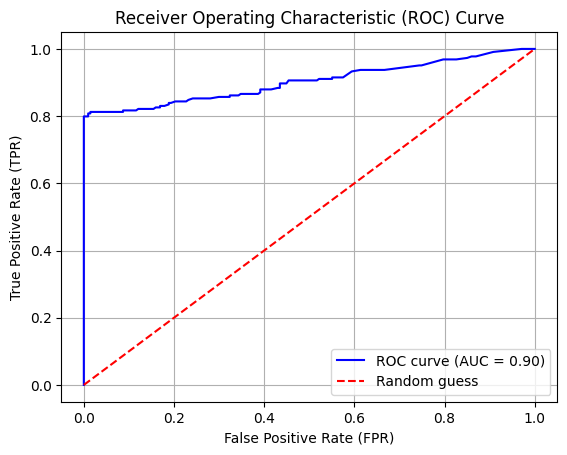

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()
